# Model Selection - ABC

In [6]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, KernelDensity
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

#### **Auxiliary Functions**

Sample from Triangular Uniform 

In [7]:
function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end;

Moving Averge Functions

In [8]:
MA2(current, u,t) = u[current+2] + u[current + 1] * t[1] + u[current] * t[2]

function genMA2(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA2.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

MA1(current, u,t) = u[current+1] + u[current] * t[1]

function genMA1(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA1.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end;

AutoCovariance

In [9]:
function abcautocov_distance(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
    rho = (ay - az)^2+(ay2 - az2)^2
    return rho
end
autocov_vectorize(z)    = abcautocov_distance(y,z);

Likelihood for Moving Average 

In [10]:
function Ger_SimgaM2(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 99
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
        elseif i == 100
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
        else
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        end
    end

    return Σ
end

function Ger_SimgaM1(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 2
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 99
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 100
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
        else
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        end
    end

    return Σ
    end;

## **Model Choice for MA(2)**

#### Synthetic Data

In [11]:
using Random
Random.seed!(3)
theta = [0.6;0.38]
n     = 100
u     = randn(n+2)
y     = MA2.((1:n),Ref(u),Ref(theta));

#### Contour Plot

In [12]:
# Contour Plot - True posterior
gθ1      = 0:0.02:1
gθ2      = -0.5:0.02:0.8
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvnM2(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM2(θ1,θ2,y)),y)
mamvnM1(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM1(θ1,θ2,y)),y);

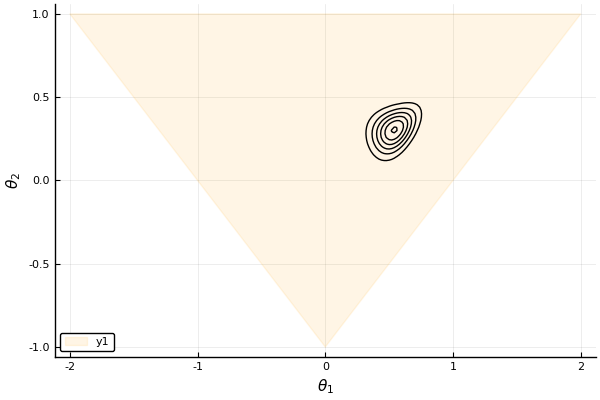

In [13]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
p1 = contour!(gθ1,gθ2, mamvnM2, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

#### Real Bayes Factor
Let's consider that $P(M_1) = P(M_2) = 0.5$, then:
$$
\frac{P(M_2 \mid y)}{P(M_1 \mid y)} = \frac{P(y \mid M_2)P(M_2)}{P(y \mid M_1)P(M_1)} =
\frac{P(y \mid M_2)}{P(y \mid M_1)} =
\frac{\int \int P(y, \theta_1, \theta_2 \mid M_2)d\theta_1d\theta_2}
{\int P(y, \theta_1 \mid M_1)d\theta_1}=
\frac{\int \int P(y \mid \theta_1, \theta_2, M_2)\pi(\theta_1,\theta_2 \mid M_2)d\theta_1d\theta_2}
{\int P(y \mid \theta_1, M_1)\pi(\theta_1 \mid M_1)d\theta_1}
$$

Since,
$$\pi(\theta_1,\theta_2 \mid M_2) = \frac{1}{4} \unicode{x1D7D9}_{1+\theta_1^2 + \theta_2^2 \leq 1}$$
$$\pi(\theta_1 \mid M_1) = \frac{1}{2} \unicode{x1D7D9}_{\theta_1^2\leq 1}$$


In [14]:
Ns = 20_000
# Z = mamvnM2.(rand(Ns),rand(Ns) .- 0.5)
Z = mamvnM2.(rand(Ns),rand(Ns))
ZM2 = sum(Z)/Ns
ZM1 = sum(mamvnM1.(rand(Ns),0))/Ns

1.4049039649715063e-60

In [15]:
BF = (ZM2/4)/(ZM1/2)
PM2= (BF)/(1+BF)
PM1= 1-(BF)/(1+BF)
BF,PM2,PM1

(20.024637574860527, 0.9524367544296832, 0.04756324557031677)

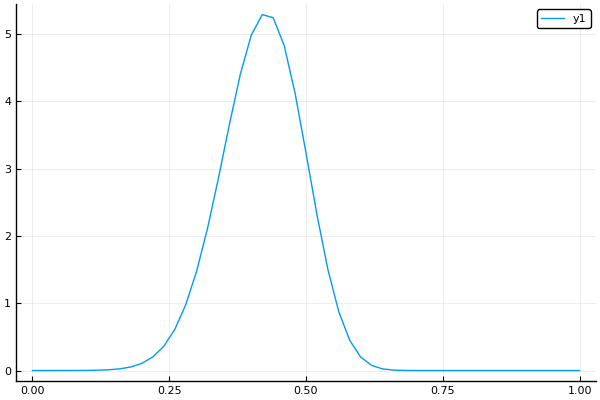

In [16]:
plot(gθ1,exp.(log.(mamvnM1.(gθ1,0)) .- log(ZM1)))

## ABC Model Choice

In [17]:
N = 10^6        # number of trials
n = length(y) # sample size
theta_ms= rand_TriUniform(N)
u       = randn(N,n+2)
zm2     = genMA2(u,theta_ms,n,N);

rho_M2 = mapslices(autocov_vectorize, zm2, dims =2)[:];
epsilon_M2 = quantile.(Ref(rho_M2[:]),[10,1,0.1,0.01]./100)

4-element Array{Float64,1}:
 1646.3143643043277   
  159.60357868913658  
   16.69488584408776  
    1.5864534323687307

In [18]:
function ModelChoiceABC(ϵ,Nm=100)
    mi = zeros(Nm)
    θM = zeros(Nm,2)
    for i = 1:Nm
        M = 0
        θm= [0.,0.]
        ρ = ϵ*2
        while ρ > ϵ
            M  = rand(1:2)
            u  = randn(n+2)
            if M == 1
                θm = rand(2).*2 .-1
                zm = MA1.((1:n),Ref(u),Ref(θm));
            else
                θm = rand_TriUniform(1)
                zm = MA2.((1:n),Ref(u),Ref(θm));
            end
            ρ = abcautocov_distance(y,zm)
        end 
        mi[i]   = M
        θM[i,:] = θm
    end
    return mi,θM
end

ModelChoiceABC (generic function with 2 methods)

In [19]:
pM2= zeros(length(epsilon_M2),2)
Nm = 10_000
results = ModelChoiceABC.(epsilon_M2,Nm)

4-element Array{Tuple{Array{Float64,1},Array{Float64,2}},1}:
 ([2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0  …  2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0], [0.410744 0.476078; 0.212923 0.739851; … ; 0.524764 0.365052; 0.897807 -0.66625])
 ([2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0  …  2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0], [0.528871 0.642496; 0.495805 0.54755; … ; 0.263429 0.934451; 0.551883 0.74799])  
 ([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.362589 0.654636; 0.404607 0.476256; … ; 0.416176 0.299221; 0.564912 0.599295])
 ([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.492941 0.42699; 0.613475 0.514478; … ; 0.325659 0.386477; 0.192023 0.192693]) 

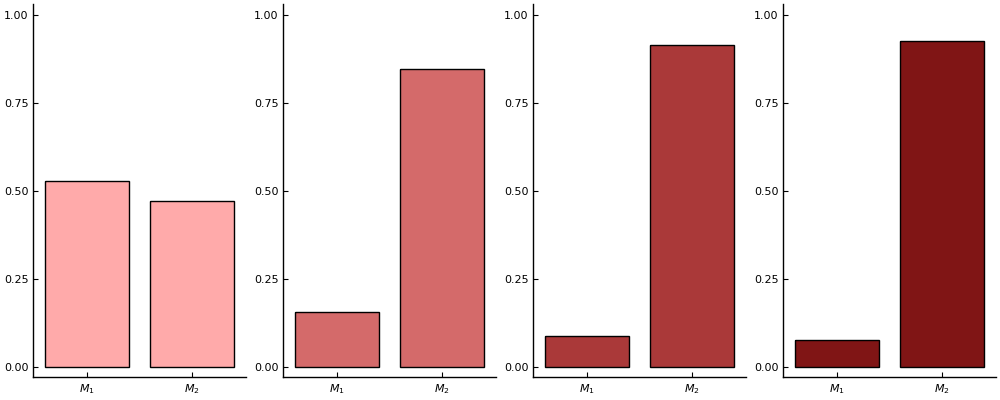

In [20]:
for i = 1:length(epsilon_M2)
    pM2[i,2] = sum(results[i][1] .== 2)/Nm
    pM2[i,1] = 1-sum(results[i][1] .== 2)/Nm
end
xbar = [L"M_1",L"M_2"]
colorsbar = ["#FFAAAA","#D46A6A","#AA3939","#801515"]
b = []
for i = 1:4
    push!(b,bar(xbar,pM2[i,:],fillcolor=colorsbar[i],ylims=[0,1],legend=false,grid=false))
end 
plot(b[1],b[2],b[3],b[4],layout=(1,4),size=(1000,400))

## **Model Choice for MA(1)**

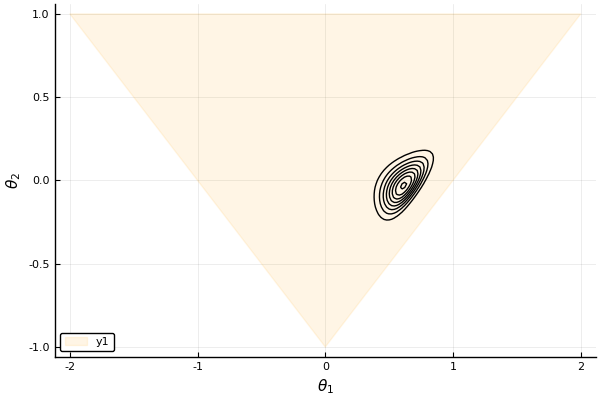

In [21]:
Random.seed!(3)
theta = [0.6;0.0]
n     = 100
u     = randn(n+2)
y     = MA2.((1:n),Ref(u),Ref(theta));

# Contour Plot - True posterior
gθ1      = 0:0.02:1
gθ2      = -0.5:0.02:0.8
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvnM2(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM2(θ1,θ2,y)),y)
mamvnM1(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM1(θ1,θ2,y)),y);

plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
p1 = contour!(gθ1,gθ2, mamvnM2, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

#### Real Bayes Factor

In [22]:
Ns = 20_000
# Z = mamvnM2.(rand(Ns),rand(Ns) .- 0.5)
Z = mamvnM2.(rand(Ns),rand(Ns))
ZM2 = sum(Z)/Ns
ZM1 = sum(mamvnM1.(rand(Ns),0))/Ns

BF = (ZM2/4)/(ZM1/2)
PM2= (BF)/(1+BF)
PM1= 1-(BF)/(1+BF)
BF,PM2,PM1

(0.05447295101046494, 0.05165893630392832, 0.9483410636960716)

#### ABC Model Choice

In [29]:
N = 10^6        # number of trials
n = length(y) # sample size
theta_ms= rand_TriUniform(N)
u       = randn(N,n+2)
zm2     = genMA2(u,theta_ms,n,N);

rho_M1 = mapslices(autocov_vectorize, zm1, dims =2)[:];
epsilon_M1 = quantile.(Ref(rho_M1[:]),[10,1,0.1,0.01]./100);

UndefVarError: UndefVarError: zm1 not defined

In [24]:
pM1= zeros(length(epsilon_M2),2)
Nm = 10_000
results = ModelChoiceABC.(epsilon_M2,Nm)

4-element Array{Tuple{Array{Float64,1},Array{Float64,2}},1}:
 ([1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0], [0.505941 -0.788407; 0.410744 0.476078; … ; 0.445572 -0.267494; 0.149902 -0.548854])
 ([2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0], [0.558595 -0.0832289; 0.614418 -0.619355; … ; 0.77083 0.374866; 0.299266 -0.348602])
 ([1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0  …  1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0], [0.334257 -0.644004; 0.674289 -0.691143; … ; 0.539818 -0.639617; 0.442956 0.262847])
 ([1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0], [0.264249 -0.112748; 0.577895 -0.566184; … ; 0.403516 0.876089; 0.375482 0.296962]) 

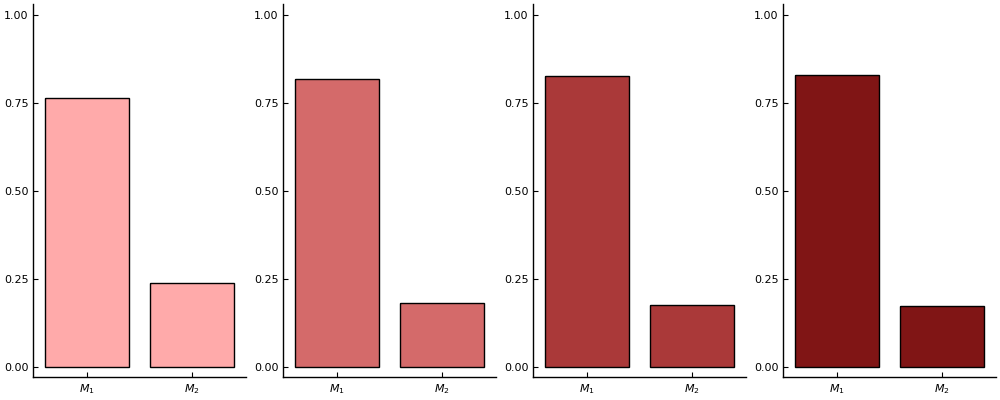

In [25]:
for i = 1:length(epsilon_M2)
    pM1[i,2] = sum(results[i][1] .== 2)/Nm
    pM1[i,1] = 1-sum(results[i][1] .== 2)/Nm
end
xbar = [L"M_1",L"M_2"]
colorsbar = ["#FFAAAA","#D46A6A","#AA3939","#801515"]
b = []
for i = 1:4
    push!(b,bar(xbar,pM1[i,:],fillcolor=colorsbar[i],ylims=[0,1],legend=false,grid=false))
end 
plot(b[1],b[2],b[3],b[4],layout=(1,4),size=(1000,400))

4×2 Array{Float64,2}:
 0.5282  0.4718
 0.155   0.845 
 0.0874  0.9126
 0.0756  0.9244